# Walmart Sales Analysis, Customer Segmentation and Sales Forecasting.

**In this notebook we are gonna dive into this walmart sales data dated 2011-2015. Frst i did some EDA to understand the data and then Created a basic Clustering model for customer segemtation. Finally, I ended the analysis by creating a sale forcasting time series model. I'll keep things simple and will walk through every step i did in this analysis.**

### Let's Start

# Loading Necessary libraries and Dataset.

In [1]:
try:
    import pandas as pd
except ImportError:
    print("Error: Could not import the pandas library.")
else:
    try:
        sales_data = pd.read_csv("/kaggle/input/walmart-sales-analysis/Walmart.csv")
    except pd.errors.ParserError:
        print("Error: Could not parse the CSV file.")
    else:
        try:
            from pylab import rcParams
            rcParams['figure.figsize'] = 18, 8
        except PlotSetError:
            print("Coudn't set default plot size")
        else:
            print("Imported necessary libraries and loaded data successfully.")


Imported necessary libraries and loaded data successfully.


# Overviewing the data

In [43]:
sales_data.head()

,Order ID,Order Date,Ship Date,Customer Name,Country,City,State,Category,Product Name,Sales,Quantity,Profit
0,CA-2013-138688,2013-06-13,2013-06-17,Darrin Van Huff,United States,Los Angeles,California,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2.0,True
1,CA-2011-115812,2011-09-06,2011-06-14,Brosina Hoffman,United States,Los Angeles,California,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.86,7.0,True
2,CA-2011-115812,2011-09-06,2011-06-14,Brosina Hoffman,United States,Los Angeles,California,Art,Newell 322,7.28,4.0,True
3,CA-2011-115812,2011-09-06,2011-06-14,Brosina Hoffman,United States,Los Angeles,California,Phones,Mitel 5320 IP Phone VoIP phone,907.15,4.0,True
4,CA-2011-115812,2011-09-06,2011-06-14,Brosina Hoffman,United States,Los Angeles,California,Binders,DXL Angle-View Binders with Locking Rings by S...,18.50,3.0,True


In [56]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       3203 non-null   object 
 1   Order Date     3203 non-null   object 
 2   Ship Date      3203 non-null   object 
 3   Customer Name  3203 non-null   object 
 4   Country        3203 non-null   object 
 5   City           3203 non-null   object 
 6   State          3203 non-null   object 
 7   Category       3203 non-null   object 
 8   Product Name   3203 non-null   object 
 9   Sales          3203 non-null   float64
 10  Quantity       3203 non-null   float64
 11  Profit         3203 non-null   float64
dtypes: float64(3), object(9)
memory usage: 300.4+ KB


> ***Descriptive Stats***

In [2]:
sales_data.describe()

,Sales,Quantity,Profit
count,3203.000000,3203.000000,3203.000000
mean,226.493266,3.828910,33.849138
std,524.876911,2.260947,174.109155
min,0.990000,1.000000,-3399.980000
25%,19.440000,2.000000,3.850000
50%,60.840000,3.000000,11.170000
75%,215.810000,5.000000,33.000000
max,13999.960000,14.000000,6719.980000


# Feature Engineering

> ***Removing outliers***
I found that there are some outliers in the sales and profit columns only after plotting but for the sake of the continuity i'm removing them here. They are not really outliers but since this only high value of (13999.96) in sales and (6719.98) in profit. I thought of removing them as it out severly skew the ML Models.

In [3]:
sales_data[["Order Date","Ship Date"]]=sales_data[["Order Date","Ship Date"]].apply(pd.to_datetime)
sales_data=sales_data[sales_data['Profit'] < 6000]
sales_data=sales_data[sales_data['Sales'] < 8000]

In [4]:
sales_data.describe()

,Sales,Quantity,Profit
count,3201.000000,3201.000000,3201.000000
mean,219.703318,3.828491,31.668635
std,443.318974,2.261557,127.793313
min,0.990000,1.000000,-3399.980000
25%,19.440000,2.000000,3.850000
50%,60.810000,3.000000,11.170000
75%,215.590000,5.000000,32.930000
max,5083.960000,14.000000,1906.490000


# EDA Through Plots

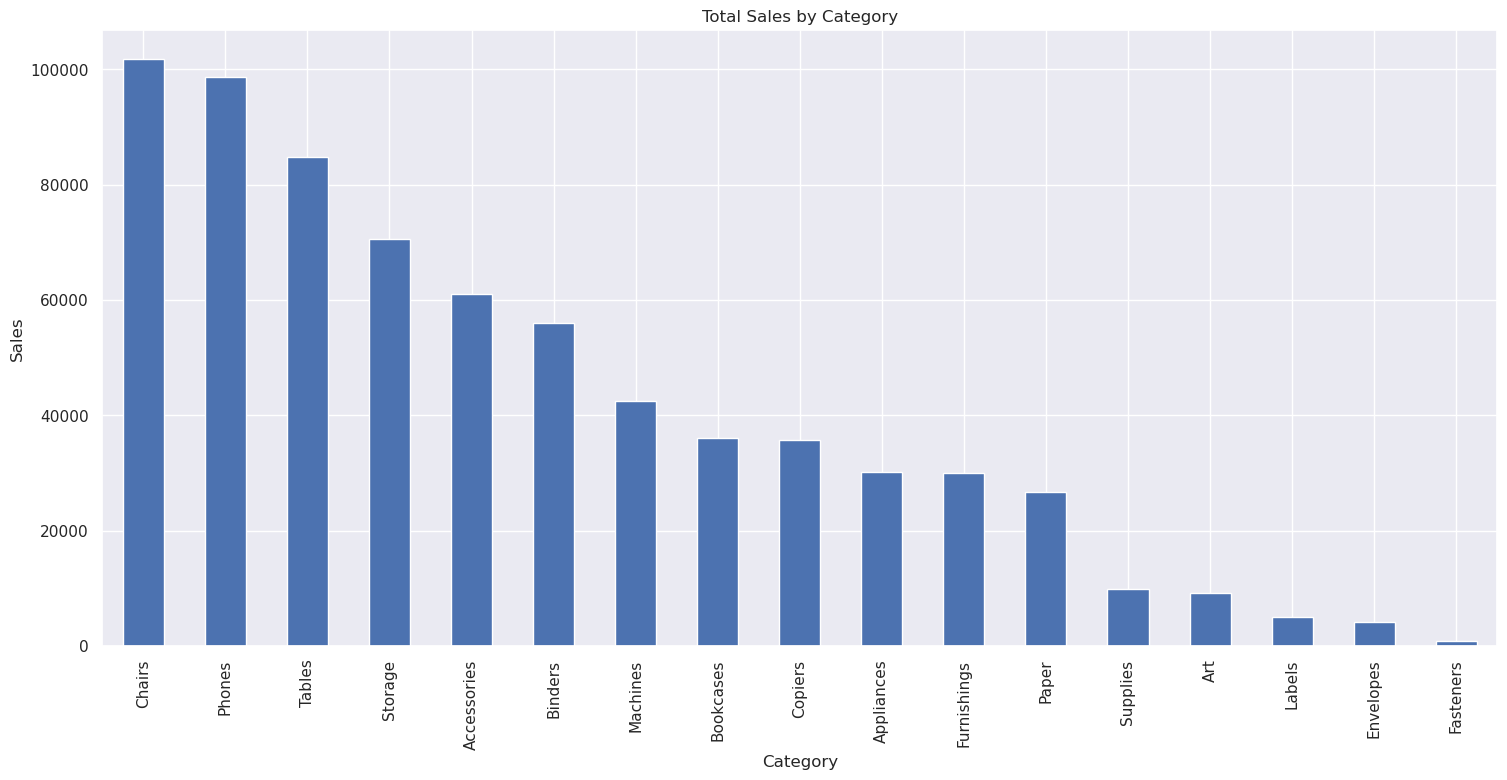

In [60]:
import matplotlib.pyplot as plt

# Group the data by category and sum the sales
category_sales = sales_data.groupby("Category")["Sales"].sum()

# Sort the sales by descending order and plot a bar chart
category_sales.sort_values(ascending=False).plot(kind="bar")
plt.title("Total Sales by Category")
plt.xlabel("Category")
plt.ylabel("Sales")
plt.show()

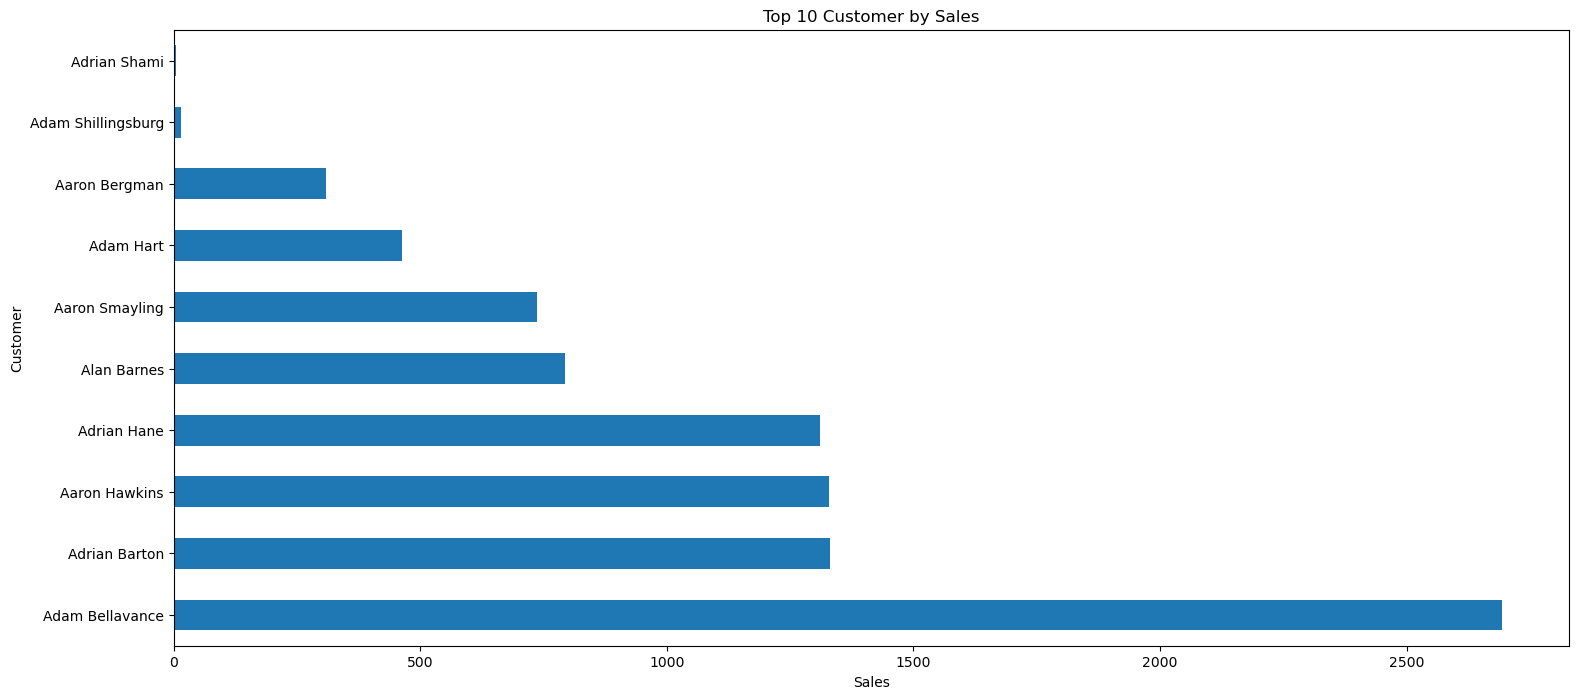

In [6]:
# Group the data by customer and sum the sales
customer_sales = sales_data.groupby("Customer Name")["Sales"].sum().head(10)

# Sort the sales by descending order and plot a horizontal bar chart
customer_sales.sort_values(ascending=False).plot(kind="barh")
plt.title("Top 10 Customer by Sales")
plt.xlabel("Sales")
plt.ylabel("Customer")
plt.show()

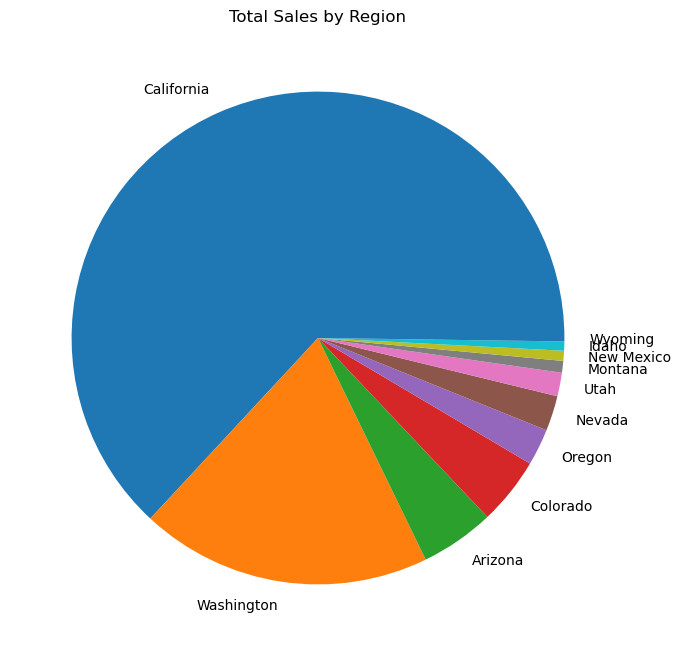

In [19]:
# Group the data by region and sum the sales
region_sales = sales_data.groupby("State")["Sales"].sum()

# Sort the sales by descending order and plot a pie chart
region_sales.sort_values(ascending=False).plot(kind="pie")
plt.title("Total Sales by Region")
plt.ylabel("")
plt.show()

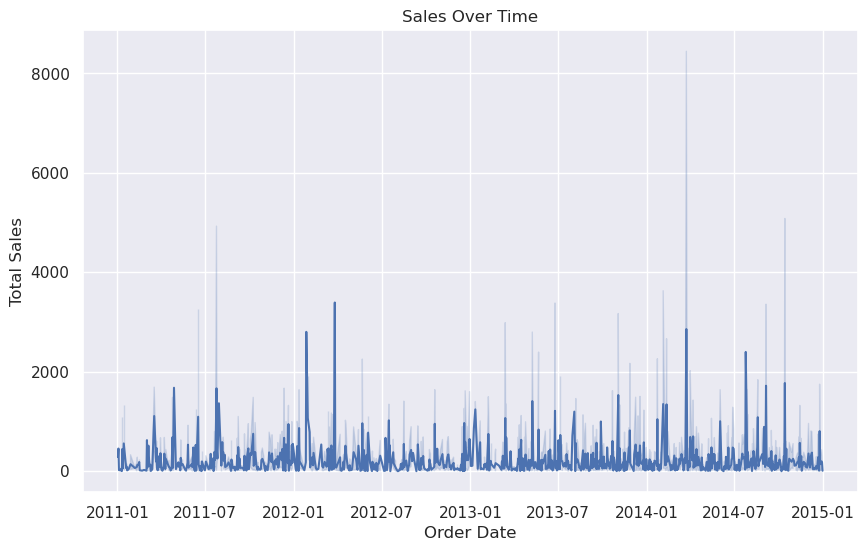

In [24]:
plt.figure(figsize=(10,6))
sns.lineplot(x="Order Date", y="Sales", data=sales_data)
plt.title('Sales Over Time')
plt.ylabel('Total Sales')
plt.xlabel('Order Date')
plt.show()

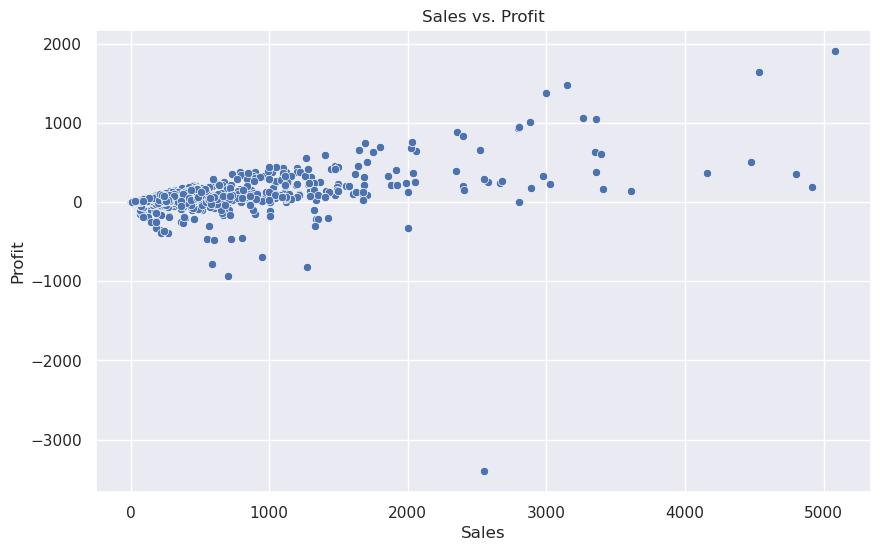

In [62]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="Sales", y="Profit", data=sales_data)
plt.title('Sales vs. Profit')
plt.ylabel('Profit')
plt.xlabel('Sales')
plt.show()

# Building ML Models

# 1. Customer Segmentation

In [7]:
# Backing up original data before altering
backup=sales_data.copy(deep=True)

> ***Importing Necessary libaries for K-Means Clustering***

In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

> ***Turning Catogorial values into numbers by assigning each category to a specific number. This is done by LabelEncoder***

In [9]:
# encode categorical variables
le = LabelEncoder()
sales_data["Country"] = le.fit_transform(sales_data["Country"])
sales_data["City"] = le.fit_transform(sales_data["City"])
sales_data["State"] = le.fit_transform(sales_data["State"])
sales_data["Category"] = le.fit_transform(sales_data["Category"])
sales_data["Product Name"] = le.fit_transform(sales_data["Product Name"])

> ***StandardScaler performs the task of Standardization. Usually a dataset contains variables that are different in scale. For e.g. an Employee dataset will contain AGE column with values on scale 20-70 and SALARY column with values on scale 10000-80000.
As these two columns are different in scale, they are Standardized to have common scale while building machine learning model.***

In [10]:
# scale numerical features
scaler = StandardScaler()
sales_data[["Sales", "Quantity", "Profit"]] = scaler.fit_transform(sales_data[["Sales", "Quantity", "Profit"]])


> ***Running actual K-Means model based on those 3 Columns***

In [11]:
# perform K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
sales_data["Cluster"] = kmeans.fit_predict(sales_data[["Sales", "Quantity", "Profit"]])

> ***Plotting the findings***

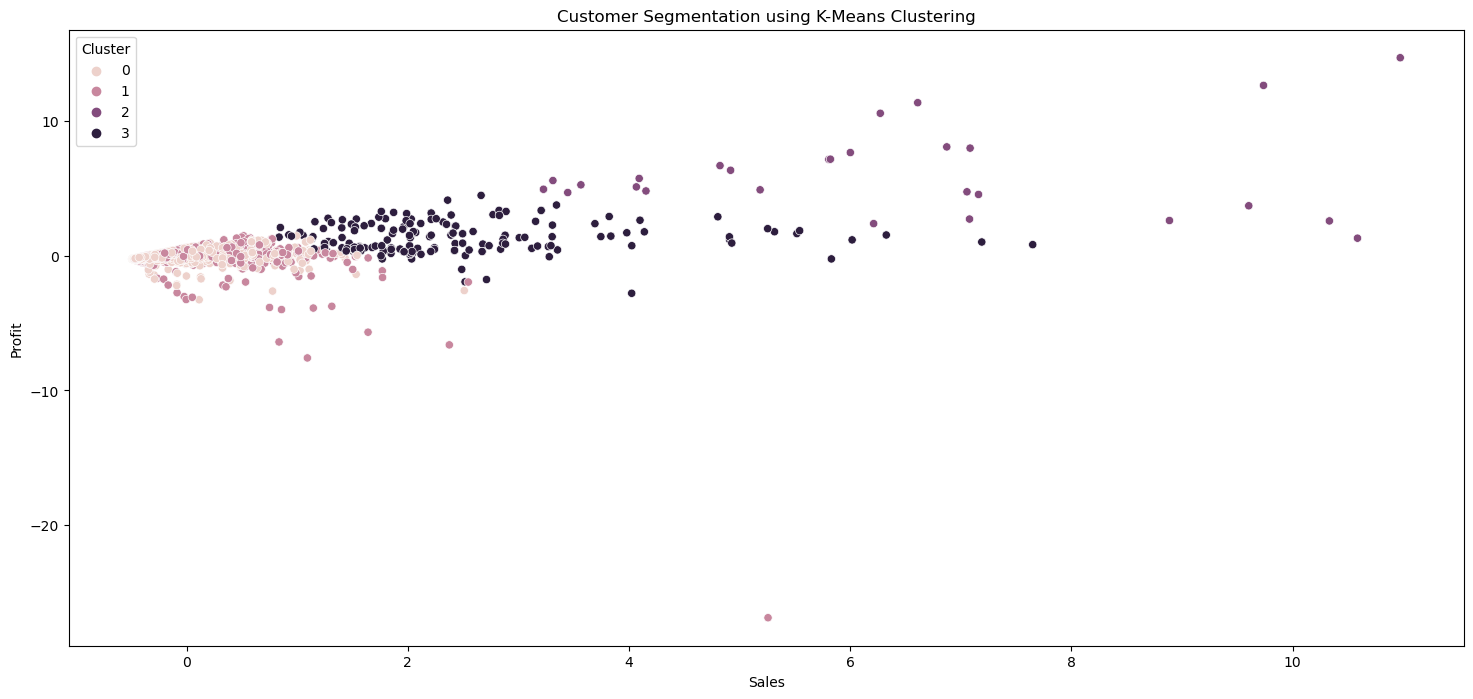

In [12]:
# visualize the clusters
sns.scatterplot(data=sales_data, x="Sales", y="Profit", hue="Cluster")
plt.title("Customer Segmentation using K-Means Clustering")
plt.show()

*The output of the customer segmentation analysis shows that the customers can be clustered into four distinct groups based on their purchasing behavior.*

* Group 0 has the highest average purchase amount and consists of customers who frequently purchase appliances, tables, and phones. These customers are likely to be businesses or organizations that require these types of products for their operations.

* Group 1 has the lowest average purchase amount and consists of customers who mainly purchase small office supplies, such as labels and self-adhesive address labels. These customers are likely to be individuals or small businesses that require basic office supplies for their daily operations.

* Group 2 has a moderate average purchase amount and consists of customers who mainly purchase office furniture and storage products. These customers are likely to be businesses or organizations that are setting up new offices or renovating existing ones.

* Group 3 has a relatively high average purchase amount and consists of customers who mainly purchase office supplies, such as binders and desk accessories. These customers are likely to be businesses or organizations that require a mix of basic office supplies and some higher-end products.

*By segmenting the customers into these groups, businesses can tailor their marketing and sales strategies to target each group more effectively. For example, they can create targeted advertising campaigns for each group or offer special promotions on products that are popular among a specific group. This can help businesses increase their sales and improve customer loyalty.*



***Moving On to Sales Forecasting***

> ***Previewing the current sales trend***

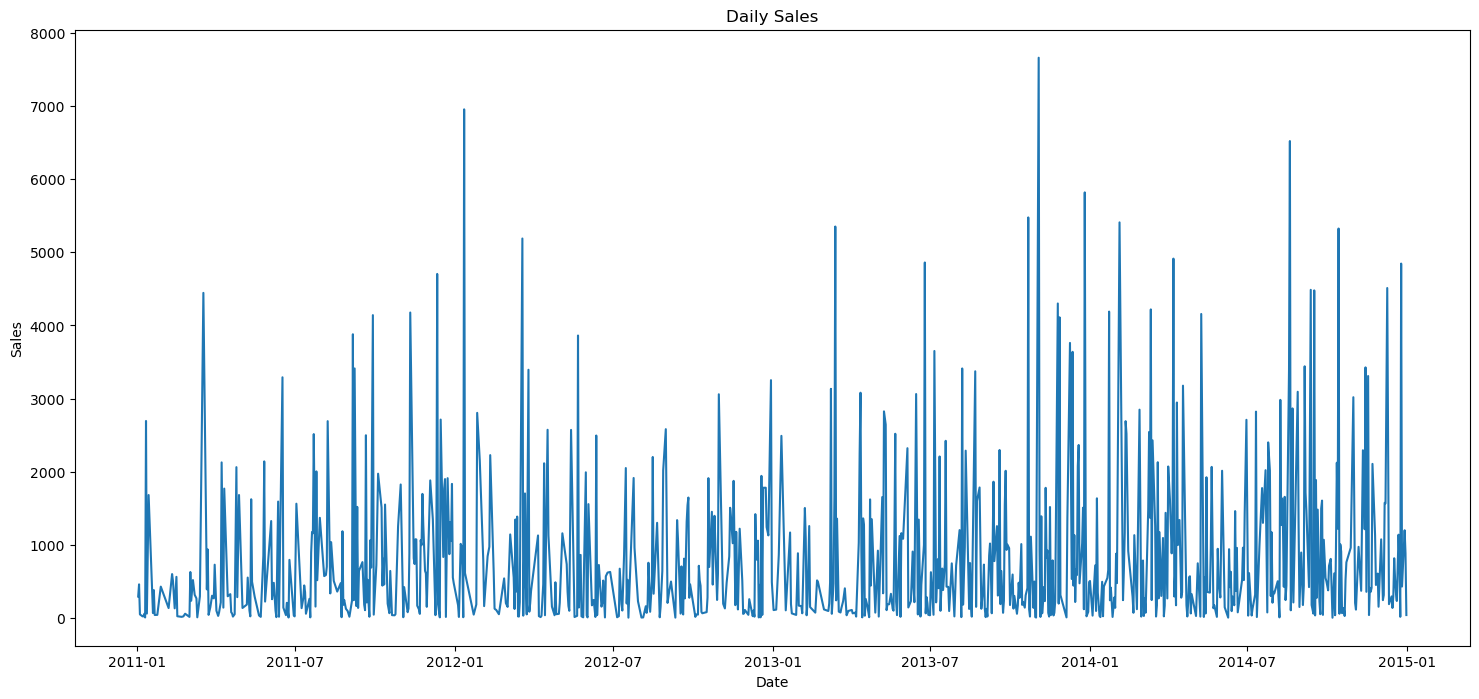

In [13]:
# Group the sales data by Order Date and sum up the Sales column for each day
daily_sales = backup.groupby('Order Date')['Sales'].sum()

# Create a new dataframe with the daily sales time-series data
daily_sales_df = pd.DataFrame({'Order Date': daily_sales.index, 'Sales': daily_sales.values})

# Set the Order Date column as the index of the dataframe
daily_sales_df.set_index('Order Date', inplace=True)

# Create a time-series plot of the daily sales data
plt.plot(daily_sales)
plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# 2. Time-Series Model (Sales Forecasting)

In [14]:
# Loading Necessary Library
from prophet import Prophet

# Prepare the data for time-series forecasting
df = backup.groupby('Order Date')['Sales'].sum().reset_index()
df = df.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

# Create and train the model
model = Prophet()
model.fit(df)


# Make future sales predictions
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)


18:17:46 - cmdstanpy - INFO - Chain [1] start processing
18:17:46 - cmdstanpy - INFO - Chain [1] done processing


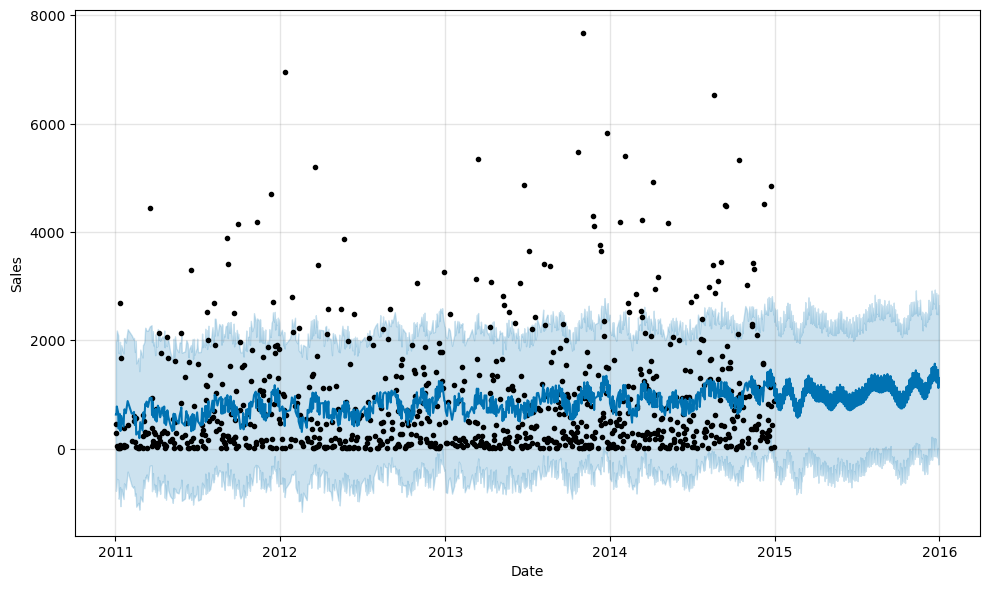

In [15]:
# Plot the forecast
fig = model.plot(forecast, xlabel='Date', ylabel='Sales')

*Based on the time-series forecasting analysis, we can see that the sales for the given dataset generally increased over time with some seasonal fluctuations. The forecast model predicts a continuing upward trend in sales for the next year, with a peak in sales around mid-2014.*

*The predicted sales values can be used to plan for future demand and optimize inventory levels. Additionally, the forecast model can be adjusted and improved over time as more data becomes available, allowing for more accurate predictions and better supply chain management.*

# 3. Anamoly Detection

> ***This is a short ML model to detect anamoly in the data using various parameters***

In [16]:
# Backing up Data
backup2=backup.copy(deep=True)

In [17]:
# Import necessary libraries
from sklearn.ensemble import IsolationForest

# Select the 'Sales' column for anomaly detection
X = backup2[['Sales']]

# Initialize the Isolation Forest model with the desired settings
model = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.05, random_state=42)

# Fit the model on the data
model.fit(X)

# Predict the anomalies in the data
y_pred = model.predict(X)

# Add the predicted labels to the dataframe
backup2['Anomaly'] = y_pred

# Print the anomalies in the data
backup2[backup2['Anomaly'] == -1]


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


,Order ID,Order Date,Ship Date,Customer Name,Country,City,State,Category,Product Name,Sales,Quantity,Profit,Anomaly
6,CA-2011-115812,2011-09-06,2011-06-14,Brosina Hoffman,United States,Los Angeles,California,Tables,Chromcraft Rectangular Conference Tables,1706.18,9.0,85.31,-1
13,CA-2012-106320,2012-09-25,2012-09-30,Emily Burns,United States,Orem,Utah,Tables,Bretford CR4500 Series Slim Rectangular Table,1044.63,3.0,240.26,-1
21,CA-2011-106376,2011-05-12,2011-10-12,Brendan Sweed,United States,Gilbert,Arizona,Art,Hunt BOSTON Model 1606 High-Volume Electric Pe...,1113.02,8.0,111.30,-1
72,CA-2013-145625,2013-12-09,2013-09-18,Kelly Collister,United States,San Diego,California,Accessories,Logitech P710e Mobile Speakerphone,3347.37,13.0,636.00,-1
80,CA-2012-130890,2012-02-11,2012-06-11,Jas O'Carroll,United States,Los Angeles,California,Tables,"Bevis Round Bullnose 29"" High Table Top",1038.84,5.0,51.94,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3091,CA-2013-160717,2013-07-06,2013-12-06,Maria Etezadi,United States,Santa Barbara,California,Phones,Samsung Galaxy Mega 6.3,3023.93,9.0,226.79,-1
3134,CA-2013-146913,2013-01-11,2013-06-11,Sylvia Foulston,United States,San Francisco,California,Chairs,Office Star - Professional Matrix Back Chair w...,1403.92,5.0,70.20,-1
3161,CA-2012-164301,2012-03-26,2012-03-30,Ellis Ballard,United States,Seattle,Washington,Tables,Bush Advantage Collection Racetrack Conference...,3393.68,8.0,610.86,-1
3177,CA-2013-129630,2013-05-09,2013-05-09,Ionia McGrath,United States,San Francisco,California,Copiers,Canon PC1060 Personal Laser Copier,2799.96,5.0,944.99,-1


*The above Results are the model speculation of anamoly in the sales based on other variables. It might be wrong or right which can be found only if we dive deep into the data. This analysis can help businesses identify unusual patterns or anomalies in the sales data, such as sudden drops or spikes in sales, which could be an indication of issues in the supply chain, customer behavior, or other factors that require further investigation and corrective action.*

***I Hope this notebook was intresting and useful. I used very basic Ml models which can be tuned accordingly to the data to get better understanding of the sales. If you like the Notebook drop a upvote.***

# The End